In [ ]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly
!pip install click
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
# tf.io.gfile.listdir(gs_folder_bert)

# Pipeline for Next Measure Classification 
1.   Data Loading & Cleaning
2.   Data Preprocessing as per Bert fine tuning requirements
3.   Defining model architecture and loading in memory 
4.   changes in last layers applying denses layers and   softmax
5. saving the model and loading back again to make predictions 



In [ ]:
import pandas as pd
import numpy as np
import click
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams

import os
from matplotlib.ticker import MaxNLocator

import numpy as np

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# # Load the required submodules
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report ,confusion_matrix
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 5,5

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm




# 1. Data Loading & Cleaning



In [ ]:
def load_data(file_name,file_sent):
  """
  load data and clean it (lowering solutions and predicted measures)
  returns dataframe cleaned
  """
  if file_sent == "train":
    curated_data=pd.read_excel(file_name)
    curated_data["Solution"]=curated_data["Solution"] + " " + curated_data["GSI"] + " " + curated_data["CU"] + " " + curated_data["Entity"] + " " + curated_data["Attribute"]
    curated_data=curated_data.dropna(subset=["Check"])
    curated_data=curated_data[["Solution","Predicted measures","Check"]]
    curated_data['Solution'] = curated_data['Solution'].str.lower()
    curated_data['Predicted measures'] = curated_data['Predicted measures'].str.lower()
    print("Numnber of rows in data :",curated_data.shape[0],"\n")
    print("Number of columns in data :",curated_data.shape[1],"\n")
    
    sns.countplot(curated_data.Check)
    plt.xlabel('Classes')
    plt.ylabel('Number of counts')
  else:
    curated_data=pd.read_excel(file_name)
    curated_data["Solution"]=curated_data["Solution"] + " " + curated_data["GSI"] + " " + curated_data["CU"] + " " + curated_data["Entity"] + " " + curated_data["Attribute"]
    curated_data=curated_data.dropna(subset=["Predicted measures"])
    curated_data=curated_data[["Solution","Predicted measures"]]
    curated_data['Solution'] = curated_data['Solution'].str.lower()
    curated_data['Predicted measures'] = curated_data['Predicted measures'].str.lower()
    print("Numnber of rows in data :",curated_data.shape[0],"\n")
    print("Number of columns in data :",curated_data.shape[1],"\n")
    
    # sns.countplot(curated_data.Check)
    # plt.xlabel('Classes')
    # plt.ylabel('Number of counts')

  
  return curated_data

In [ ]:
df=pd.read_excel("Classifier Results.xlsx")
mapping_results={"Incorrect":1,"Correct":0}

In [ ]:
df["Classification Result"]=df["Classification Result"].map(mapping_results)

Numnber of rows in data : 374 

Number of columns in data : 3 

Numnber of rows in data : 906 

Number of columns in data : 3 



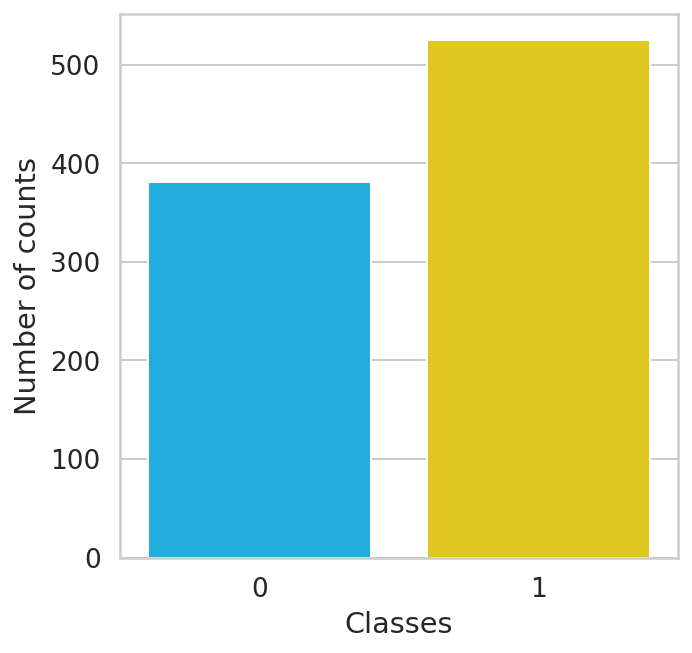

In [ ]:
data1=load_data(file_name="next_measure_data.xlsx",file_sent="train")
updated_data=load_data(file_name="Classifier Results.xlsx",file_sent="train")

In [ ]:
final_data=data1.append(updated_data)

In [ ]:
final_data.shape

(1280, 3)

##### After looking upon this graph that we can say that we are dealing with is balanced for now , because data given to me is quite less , train test validation splits will be very low on this for eg 314 train 30 test 30 in valdiation 

# 2. Data Preprocessing Pipeline 

This directory contains the configuration, vocabulary, and a pre-trained checkpoint for bert 12 layers encoders models

The BERT tokenizer
To fine tune a pre-trained model you need to be sure that you're using exactly the same tokenization, vocabulary, and index mapping as you used during training

In [ ]:
def encode_sentence(s, tokenizer):
  gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
  tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    do_lower_case=True)
  tokens = list(tokenizer.tokenize(s))
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(data, tokenizer):
  num_examples = len(data["Solution"])

  sentence1 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(data["Solution"])])
  sentence2 = tf.ragged.constant([encode_sentence(s, tokenizer)  for s in np.array(data["Solution"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()


  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()


  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,   # attention_mask
      'input_type_ids': input_type_ids} 

  return inputs

def bert_tokenizer():
  gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
  tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),do_lower_case=True)
  return tokenizer

# 3. Train test validation split

In [ ]:
def train_test_validation_split(data):
  train,test=train_test_split(data,test_size=.3,random_state=12)
  validation,test=train_test_split(test,test_size=.5,random_state=12)

  return train,test,validation

In [ ]:
train,test,validation=train_test_validation_split(final_data)

# 4. Preprocessing every dataset 

In [ ]:
train_encoded = bert_encode(train[["Solution","Predicted measures"]], tokenizer=bert_tokenizer())
train_labels = train['Check']

validation_encoded = bert_encode(validation[["Solution","Predicted measures"]], tokenizer=bert_tokenizer())
validation_labels = validation['Check']

test_encoded = bert_encode(test[["Solution","Predicted measures"]], tokenizer=bert_tokenizer())
test_labels = test['Check']

In [ ]:
for key, value in train_encoded.items():
  print(f'{key} shape: {value.shape}')
print(f'labels shape: {train_labels.shape}')

input_word_ids shape: (896, 57)
input_mask shape: (896, 57)
input_type_ids shape: (896, 57)
labels shape: (896,)


# 5. Training model  

In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config,num_labels=2)

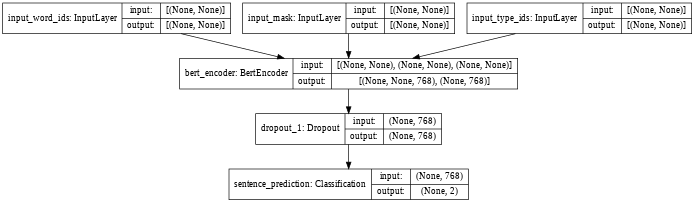

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
# Set up epochs and steps
epochs = 10
batch_size = 32
eval_batch_size = 32

train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

history=bert_classifier.fit(
      train_encoded, train_labels,
      validation_data=(validation_encoded, validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/10
28/28 [==============================] - 370s 13s/step - loss: 0.6900 - accuracy: 0.5108 - val_loss: 0.5718 - val_accuracy: 0.5781
Epoch 2/10
28/28 [==============================] - 361s 13s/step - loss: 0.5668 - accuracy: 0.6823 - val_loss: 0.4670 - val_accuracy: 0.8385
Epoch 3/10
28/28 [==============================] - 364s 13s/step - loss: 0.4394 - accuracy: 0.8203 - val_loss: 0.3064 - val_accuracy: 0.9115
Epoch 4/10
28/28 [==============================] - 355s 13s/step - loss: 0.2920 - accuracy: 0.9092 - val_loss: 0.2917 - val_accuracy: 0.8750
Epoch 5/10
28/28 [==============================] - 355s 13s/step - loss: 0.2426 - accuracy: 0.9171 - val_loss: 0.1700 - val_accuracy: 0.9427
Epoch 6/10
28/28 [==============================] - 360s 13s/step - loss: 0.1523 - accuracy: 0.9570 - val_loss: 0.1454 - val_accuracy: 0.9635
Epoch 7/10
28/28 [==============================] - 367s 13s/step - loss: 0.1286 - accuracy: 0.9602 - val_loss: 0.1780 - val_accuracy: 0.9427
Epoch 

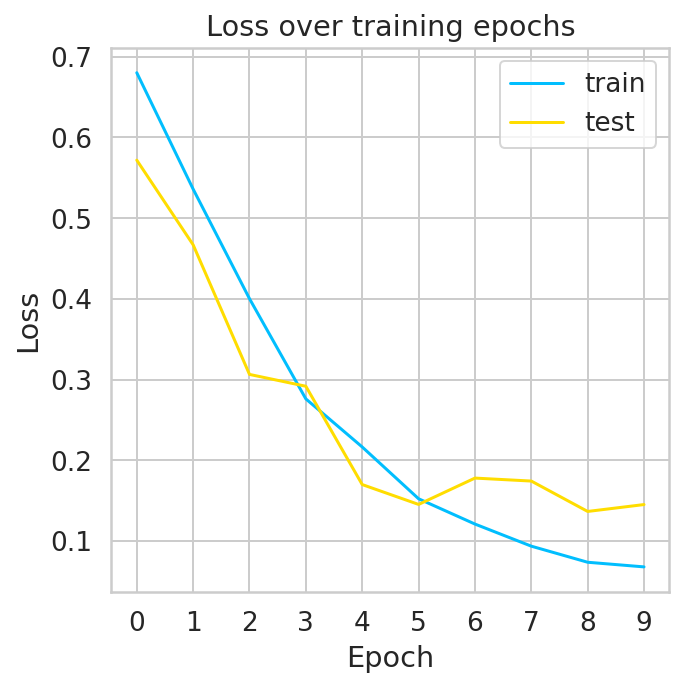

In [ ]:

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();


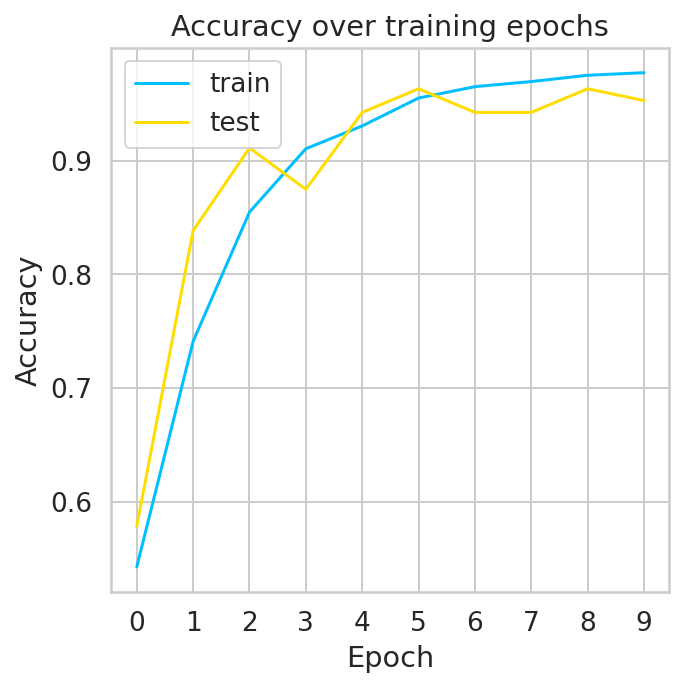

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();


In [ ]:
_, train_acc = bert_classifier.evaluate(train_encoded, train_labels)
_, test_acc = bert_classifier.evaluate(test_encoded, test_labels)

print("train acc", train_acc)
print("test acc", test_acc)

6/6 [==============================] - 19s 3s/step - loss: 0.2977 - accuracy: 0.9219
train acc 0.9866071343421936
test acc 0.921875


In [ ]:
y_pred = bert_classifier.predict(test_encoded).argmax(axis=-1)

In [ ]:
print(classification_report(test_labels, y_pred,target_names=["irrelevant","relevant"]))

              precision    recall  f1-score   support

  irrelevant       0.90      0.91      0.91        80
    relevant       0.94      0.93      0.93       112

    accuracy                           0.92       192
   macro avg       0.92      0.92      0.92       192
weighted avg       0.92      0.92      0.92       192



In [ ]:
cm = confusion_matrix(test_labels, y_pred)
df_cm = pd.DataFrame(cm, index=["irrelevant","relevant"], columns=["irrelevant","relevant"])

Text(0.5, 18.5, 'Predicted label')

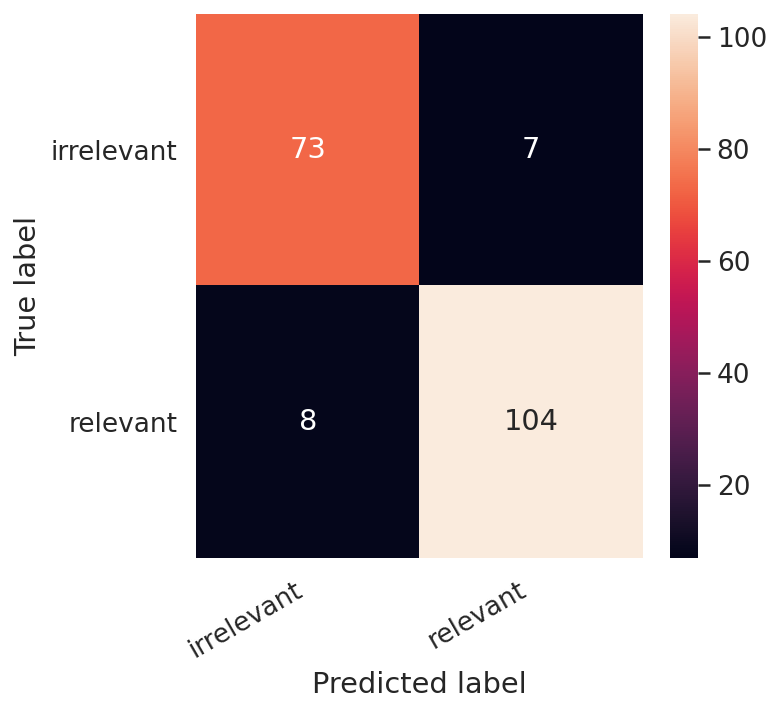

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
df_new_test=pd.read_excel("/content/dataset_marked_20200901.xlsx")

In [ ]:
df.columns

Index(['Industry', 'Sub Industry', 'Solution', 'GSI', 'CU', 'Entity',
       'Attribute', 'Predicted measures', 'Check', 'Classification Result',
       'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [ ]:
df_new_test.columns=["Industry","Sub Industry",'Solution','GSI', 'CU','Entity','Attribute','Predicted measures','Check']

In [ ]:
df_new_test.to_excel("new_test_data.xlsx")

In [ ]:
new_test_data=pd.read_excel('new_test_data.xlsx')

Numnber of rows in data : 3598 

Number of columns in data : 3 



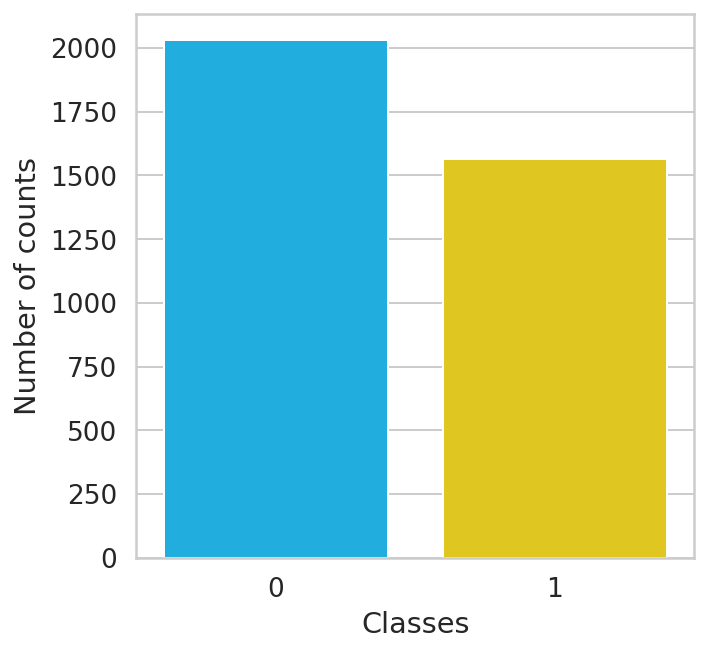

In [ ]:
new_test_data=load_data(file_name="new_test_data.xlsx",file_sent="train")

In [ ]:
new_test_encoded = bert_encode(new_test_data[["Solution","Predicted measures"]], tokenizer=bert_tokenizer())

In [ ]:
new_test_labels=new_test_data["Check"]

In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([test_encoded['input_word_ids'],
                            test_encoded['input_mask'],
                            test_encoded['input_type_ids']], training=False)

# original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
# print(original_result.numpy())
print(reloaded_result.numpy().argmax(axis=-1))

[1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 0
 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0
 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1
 1 1 0 0 1 0 1]


In [ ]:
y_pred = bert_classifier.predict(new_test_encoded).argmax(axis=-1)

In [ ]:
print(classification_report(new_test_labels, y_pred,target_names=["irrelevant","relevant"]))

              precision    recall  f1-score   support

  irrelevant       0.55      0.55      0.55      2032
    relevant       0.41      0.41      0.41      1566

    accuracy                           0.49      3598
   macro avg       0.48      0.48      0.48      3598
weighted avg       0.49      0.49      0.49      3598



# Prediction script started 

In [ ]:
class inference_engine():
  def load_file(self,file_name):
    """
    takes the filepath and return required dataframe necessary for preprocessing

    """
    curated_data=pd.read_excel(file_name)
    curated_data["Solution"]=curated_data["Solution"] + " " + curated_data["GSI"] + " " + curated_data["CU"] + " " + curated_data["Entity"] + " " + curated_data["Attribute"]
    curated_data=curated_data.dropna(subset=["Predicted measures"])
    curated_data=curated_data[["Solution","Predicted measures"]]
    curated_data['Solution'] = curated_data['Solution'].str.lower()
    curated_data['Predicted measures'] = curated_data['Predicted measures'].str.lower()
    print("Numnber of rows in data :",curated_data.shape[0],"\n")
    print("Number of columns in data :",curated_data.shape[1],"\n")

    return curated_data

  def encode_sentence(self,s, tokenizer):
    """
    takes sentences and bert tokenizer (will be download for first time)

    """
    tokenizer = bert.tokenization.FullTokenizer(
      vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
      do_lower_case=True)
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

  def bert_encode(self,data, tokenizer):
    """
    takes data and return preprocessed file
    """
    num_examples = len(data["Solution"])

    sentence1 = tf.ragged.constant([ie.encode_sentence(s, tokenizer)
        for s in np.array(data["Solution"])])
    sentence2 = tf.ragged.constant([ie.encode_sentence(s, tokenizer)
          for s in np.array(data["Solution"])])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()


    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
        [type_cls, type_s1, type_s2], axis=-1).to_tensor()


    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,   # attention_mask
        'input_type_ids': input_type_ids} 

    return inputs

  def bert_tokenizer(self):
    """
    downloads and return bert tokenizer 

    """
    gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
    tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),do_lower_case=True)
    return tokenizer

  def prediction(self,model_file_name,new_test_encoded,test_file_name):
    """
    takes preprocess data and return final_results in csv file
    """
    data=pd.read_excel(test_file_name)
    data=data.dropna(subset=["Predicted measures"])
    reloaded = tf.saved_model.load(model_file_name)
    reloaded_result = reloaded([new_test_encoded['input_word_ids'],
                            new_test_encoded['input_mask'],
                            new_test_encoded['input_type_ids']], training=False)
    
    y_pred = reloaded_result.numpy().argmax(axis=-1)
    data["Check_Predicted"]=y_pred
    data.to_csv("final_results.csv")

In [ ]:
!zip -r saved_model.zip saved_model

In [ ]:
from google.colab import files
files.download( "saved_model.zip")

In [ ]:
export_dir='./saved_model'
ie=inference_engine()
data=ie.load_file('new_test_data.xlsx')
encoded_data=ie.bert_encode(data[["Solution","Predicted measures"]],tokenizer=ie.bert_tokenizer())
ie.prediction(export_dir,encoded_data,"new_test_data.xlsx")

In [ ]:
new_test_encoded = bert_encode(data[["Solution","Predicted measures"]], tokenizer=bert_tokenizer())
# train_labels = train['Check']


# my_examples = bert_encode({
#         'Solution':['leave process	add monthly leaves to leave balance	add monthly leaves	leave summary	leader id'],
#         'Predicted measures':['']},tokenizer=bert_tokenizer())

In [ ]:
# result = bert_classifier(new_test_encoded, training=False)
y_pred = bert_classifier.predict(new_test_encoded).argmax(axis=-1)

In [ ]:
final_result=pd.read_excel("new_test_data.xlsx")
final_result=final_result.dropna(subset=["Predicted measures"])
final_result["Check"]=y_pred

final_result.to_csv("final_results.csv")

In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

In [ ]:
{"user_name": "sangeethay", "tenant_id": "cdui", "request_name": "DLDCUSmartFullTF3", "request_id": "DLDCUSmartFullTF3202010-0811-2146-a55d80e5-cdec-43c8-b6b7-588d00d75e1d","recommendation":"list"}{"user_name": "sangeethay", "tenant_id": "cdui", "request_name": "DLDCUSmartFullTF3", "request_id": "DLDCUSmartFullTF3202010-0811-2151-65857935-0a80-4111-8c7d-6ea1ddbb8a8f","recommendation":"list"}
